# **Import Library dan Dataset**

In [1]:
!pip install google-play-scraper
!pip install nltk
!pip install Sastrawi
!pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 kB 6.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import os
import requests

nltk.download('stopwords')
nltk.download('punkt')

from google_play_scraper import Sort, reviews_all
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
from IPython.display import clear_output
from tabulate import tabulate
from wordcloud import WordCloud

# Buat Direktori
daftar_nama_dir = ["Data Selection", "Preprocessing", "Transformation", "Data Mining", "GitHub","Optional"]
for nama_dir in daftar_nama_dir:
    if not os.path.exists(nama_dir):
        os.makedirs(nama_dir)

# Import Dataset dari GitHub
url1 = 'https://raw.githubusercontent.com/raffizh24/Skripsi/main/dataset-baru.csv'
response1 = requests.get(url1)
with open('GitHub/dataset-binar.csv', 'wb') as f:
    f.write(response1.content)

url2 = 'https://raw.githubusercontent.com/raffizh24/Skripsi/main/normalisasi-id.csv'
response2 = requests.get(url2)
with open('GitHub/normalisasi-id.csv', 'wb') as f:
    f.write(response2.content)

url3 = 'https://raw.githubusercontent.com/raffizh24/Skripsi/main/stopword-manual.txt'
response3 = requests.get(url3)
with open('GitHub/stopword-manual.txt', 'wb') as f:
    f.write(response3.content)

dataset_path = "/content/GitHub/dataset-binar.csv"
kamus_normalisasi_path = "/content/GitHub/normalisasi-id.csv"
stopword_file_path = "/content/GitHub/stopword-manual.txt"

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# **Program Analasis Sentimen**

## **Data Selection**

In [ ]:
# #Referensi: https://www.linkedin.com/pulse/how-scrape-google-play-reviews-4-simple-steps-using-python-kundi/
# result = reviews_all(
#     'com.binaracademy.app',
#     sleep_milliseconds=0,
#     lang='id',
#     country='id',
#     sort=Sort.NEWEST,
# )

# df = pd.DataFrame(result)

# df[['at', 'score', 'content']].sort_values(by='at', ascending=False).to_csv("Data Selection/scrapped_data.csv", index=False)

## **Preprocessing**

In [3]:
# Baca file CSV dan simpan dalam dataframe
df = pd.read_csv(dataset_path)
df_outlier = pd.read_csv(dataset_path)
df_kamus = pd.read_csv(kamus_normalisasi_path)
df_stopword = pd.read_csv(stopword_file_path)

# Tahap Cleaning
def cleaning(text):
    # Filter Data Outlier
    data_outlier = df_outlier[(df_outlier['label-rating'] != df_outlier['label-pakar'])]
    data_outlier.to_csv('Data Selection/data_outlier.csv', index=False)
    df.drop(df[(df['label-rating'] != df['label-pakar'])].index, inplace=True)
    # Menghapus Kata Berulang (Gooool -> Gool)
    pattern = re.compile(r"(.)\1{2,}", re.DOTALL)
    text = pattern.sub(r"\1\1", text)
    # Menghapus emoji, tanda baca, angka dan karakter selain huruf a-z
    text = re.sub(r'[^a-z\s]', ' ', text, flags=re.IGNORECASE)
    return text.strip()
df['ulasan'] = df['ulasan'].apply(cleaning)
df.to_csv('Preprocessing/1. Cleaning.csv', index=False)

# Tahap Case Folding
def case_folding(text):
    text = text.lower()
    return text
df['ulasan'] = df['ulasan'].apply(case_folding)
df.to_csv('Preprocessing/2. Case Folding.csv', index=False)

# Tahap Tokenizing
def tokenizing(text):
    text = word_tokenize(text)
    return text
df['ulasan'] = df['ulasan'].apply(tokenizing)
df.to_csv('Preprocessing/3. Tokenizing.csv', index=False)

# Tahap Normalization
def normalize(text):
    kamus_normalisasi = {}
    for index, row in df_kamus.iterrows():
        kata_asli = row[0]
        kata_normalisasi = row[1]
        kamus_normalisasi[kata_asli] = kata_normalisasi
    text = [kamus_normalisasi.get(token, token) for token in text]
    return text
df['ulasan'] = df['ulasan'].apply(normalize)
df.to_csv('Preprocessing/4. Normalisasi.csv', index=False)

# Tahap Stopword Removal
def stopword_removal(text):
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    # Hapus Stopword Manual (Karena Stopword Bahasa Indonesia Tidak Lengkap)
    with open(stopword_file_path, 'r') as f:
        stopword_manual = f.read().split('\n')
    text = [token for token in text if token not in stopword_manual]
    # Hapus Stopword Bawaan Sastrawi
    text = stopword.remove(' '.join(text))
    text = text.split()
    return text
df['ulasan'] = df['ulasan'].apply(stopword_removal)
df.to_csv('Preprocessing/5. Stopword.csv', index=False)

# Tahap Stemming
def stemming(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(token) for token in text]
    return text
df['ulasan'] = df['ulasan'].apply(stemming)
df.to_csv('Preprocessing/6. Stemming.csv', index=False)

# Hitung jumlah data_outlier
data_outlier = pd.read_csv("/content/Data Selection/data_outlier.csv")
print("Jumlah Data Ulasan: ", len(df))
print("Jumlah Data Outlier: ", len(data_outlier))

# Hitung Jumlah ulasan dengan Label Positif, Netral, dan Negatif
rate_positif = df[(df['label-rating'] == 'POSITIF')]
rate_negatif = df[(df['label-rating'] == 'NEGATIF')]
print("Jumlah Ulasan Positif Rating : ", len(rate_positif))
print("Jumlah Ulasan Negatif Rating : ", len(rate_negatif))

# Simpan Hasil Preprocessing
df.to_csv('Preprocessing.csv', index=False)

Jumlah Data Ulasan:  669
Jumlah Data Outlier:  44
Jumlah Ulasan Positif Rating :  536
Jumlah Ulasan Negatif Rating :  133


## **Transformation**

In [4]:
def transformation(n_test_size):
    # memuat dataset
    df = pd.read_csv('/content/Preprocessing.csv')

    # memisahkan fitur dan label
    x = df['ulasan']
    y = df['label-rating']

    # informasi dataset
    n_review = len(df.index)
    n_pos = sum(y == 'POSITIF')
    n_neg = sum(y == 'NEGATIF')

    # membagi dataset menjadi data training dan data testing
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=n_test_size, random_state=42)

    # simpan hasil data training dan testing lalu urutkan berdasarkan index
    df_train = pd.DataFrame({'ulasan': x_train, 'label': y_train})
    df_test = pd.DataFrame({'ulasan': x_test, 'label': y_test})

    # menghitung jumlah ulasan positif dan negatif pada data testing
    n_pos_test = sum(y_test == 'POSITIF')
    n_neg_test = sum(y_test == 'NEGATIF')

    # menghitung jumlah ulasan positif dan negatif pada data training
    n_pos_train = sum(y_train == 'POSITIF')
    n_neg_train = sum(y_train == 'NEGATIF')

    # ekstraksi fitur menggunakan tf-idf
    vectorizer = TfidfVectorizer()
    x_train_tfidf = vectorizer.fit_transform(x_train)
    x_test_tfidf = vectorizer.transform(x_test)
    n_feature_tfidf = x_train_tfidf.shape[1]

    # hasil ekstraksi fitur menggunakan tf-idf
    feature_names = vectorizer.get_feature_names_out()
    feature_names = np.sort(feature_names)
    df_tfidf = pd.DataFrame(x_train_tfidf.toarray(), columns=feature_names)
    df_tfidf.to_csv('Transformation/tfidf-{}.csv'.format(n_test_size), index=False)

    # seleksi fitur dengan menggunakan information gain
    selector = SelectKBest(mutual_info_classif, k='all')
    x_train = selector.fit_transform(x_train_tfidf, y_train)
    scores = selector.scores_
    selected_features = scores > 0.001
    x_train = x_train[:, selected_features]
    x_test = x_test_tfidf[:, selected_features]
    n_feature_ig = x_train.shape[1]

    # hasil ekstraksi fitur menggunakan information gain
    feature_names = feature_names[selected_features]
    feature_names = np.sort(feature_names)
    df_ig = pd.DataFrame(x_train.toarray(), columns=feature_names)
    df_ig.to_csv('Transformation/ig-{}.csv'.format(n_test_size), index=False)

    return(x_train, x_test, y_train, y_test, n_review, n_pos, n_neg, n_pos_test, n_neg_test, n_pos_train, n_neg_train, n_feature_tfidf, n_feature_ig, df_train, df_test)

## **Data Mining**

In [5]:
def data_mining(x_train, y_train, x_test, y_test, test_size, df_train, df_test):
    # membuat model klasifikasi dengan menggunakan naive bayes
    clf1 = MultinomialNB()
    clf2 = BernoulliNB()

    # melatih model naive bayes dengan data training
    clf1.fit(x_train, y_train)
    clf2.fit(x_train, y_train)

    # melakukan prediksi model naive bayes terhadap data testing
    y_pred1 = clf1.predict(x_test)
    y_pred2 = clf2.predict(x_test)

    # mendapatkan prediksi probabilitas untuk setiap kelas
    y_score1 = clf1.predict_proba(x_test)[:,1]
    y_score2 = clf2.predict_proba(x_test)[:,1]

    # Simpan Hasil Klasifikasi dengan Naive Bayes Multinomial dan Bernoulli kedalam dataframe
    df_test['nb_multinomial'] = y_pred1
    df_test['nb_bernoulli'] = y_pred2

    # Simpan df_test kedalam file csv
    df_test.to_csv('Data Mining/hasil_klasifikasi_nb_{}.csv'.format(test_size), index=True)

    # Gabungkan dan simpan df_train dan df_test kedalam file csv
    df_train = df_train.append(df_test)
    df_train.to_csv('Data Mining/hasil_dataset_{}.csv'.format(test_size),index=True)

    # bersihin output
    clear_output()

    return(y_pred1, y_pred2, y_score1, y_score2)

## **Evaluation**

In [6]:
def evaluation(y_test, y_pred1, y_pred2, y_score1, y_score2, n_pos_test, n_neg_test, n_pos_train, n_neg_train):
    # menghitung performa model dengan menggunakan confusion matrix
    cm_mnb = confusion_matrix(y_test, y_pred1)
    tp_mnb = cm_mnb[1, 1]
    fp_mnb = cm_mnb[1, 0]
    tn_mnb = cm_mnb[0, 0]
    fn_mnb = cm_mnb[0, 1]
    cm_bnb = confusion_matrix(y_test, y_pred2)
    tp_bnb = cm_bnb[1, 1]
    fp_bnb = cm_bnb[1, 0]
    tn_bnb = cm_bnb[0, 0]
    fn_bnb = cm_bnb[0, 1]

    # menghitung metrik evaluasi model multinomial
    accuracy_mnb = accuracy_score(y_test, y_pred1)
    precision_mnb = precision_score(y_test, y_pred1, pos_label='POSITIF')
    recall_mnb = recall_score(y_test, y_pred1, pos_label='POSITIF')
    f1_mnb = f1_score(y_test, y_pred1, pos_label='POSITIF')
    roc_auc_mnb = roc_auc_score(y_test, y_score1)

    # menghitung metrik evaluasi model bernoulli
    accuracy_bnb = accuracy_score(y_test, y_pred2)
    precision_bnb = precision_score(y_test, y_pred2, pos_label='POSITIF')
    recall_bnb = recall_score(y_test, y_pred2, pos_label='POSITIF')
    f1_bnb = f1_score(y_test, y_pred2, pos_label='POSITIF')
    roc_auc_bnb = roc_auc_score(y_test, y_score2)

    # menghitung jumlah ulasan yang terklasifikasi oleh model multinomial
    n_pos_mnb = tp_mnb+fn_mnb+n_pos_train
    n_neg_mnb = fp_mnb+tn_mnb+n_neg_train

    # menghitung jumlah ulasan yang terklasifikasi oleh model bernoulli
    n_pos_bnb = tp_bnb+fn_bnb+n_pos_train
    n_neg_bnb = fp_bnb+tn_bnb+n_neg_train

    return (tp_mnb, fp_mnb, tn_mnb, fn_mnb, tp_bnb, fp_bnb, tn_bnb, fn_bnb, accuracy_mnb, precision_mnb, recall_mnb, f1_mnb, roc_auc_mnb, n_pos_mnb, n_neg_mnb, accuracy_bnb, precision_bnb, recall_bnb, f1_bnb, roc_auc_bnb, n_pos_bnb, n_neg_bnb)

## **Eksekusi Transformation-Data Mining-Evaluation**

In [7]:
def evaluate_model(test_size):
    # membagi dataset menjadi data training dan data testing
    x_train, x_test, y_train, y_test, n_review, n_pos, n_neg, n_pos_test, n_neg_test, n_pos_train, n_neg_train, n_feature_tfidf, n_feature_ig, df_train, df_test = transformation(test_size)

    # membuat model klasifikasi dengan menggunakan naive bayes
    y_pred1, y_pred2, y_score1, y_score2 = data_mining(x_train, y_train, x_test, y_test, test_size, df_train, df_test)

    # memanggil fungsi untuk melakukan evaluasi model
    tp_mnb, fp_mnb, tn_mnb, fn_mnb, tp_bnb, fp_bnb, tn_bnb, fn_bnb, accuracy_mnb, precision_mnb, recall_mnb, f1_mnb, roc_auc_mnb, n_pos_mnb, n_neg_mnb, accuracy_bnb, precision_bnb, recall_bnb, f1_bnb, roc_auc_bnb, n_pos_bnb, n_neg_bnb = evaluation(y_test, y_pred1, y_pred2, y_score1, y_score2, n_pos_test, n_neg_test, n_pos_train, n_neg_train)

    # konversi accuracy, precision, recall dan f1 menjadi persen
    accuracy_mnb = accuracy_mnb*100
    precision_mnb = precision_mnb*100
    recall_mnb = recall_mnb*100
    f1_mnb = f1_mnb*100
    accuracy_bnb = accuracy_bnb*100
    precision_bnb = precision_bnb*100
    recall_bnb = recall_bnb*100
    f1_bnb = f1_bnb*100

    #konversi roc_auc menjadi 3 angka di belakang koma
    roc_auc_mnb = round(roc_auc_mnb, 3)
    roc_auc_bnb = round(roc_auc_bnb, 3)

    # menyimpan hasil evaluasi model
    skenario = pd.DataFrame({'test_size': [test_size], 'n_review': [n_review], 'n_pos': [n_pos], 'n_neg': [n_neg], 'n_pos_test': [n_pos_test], 'n_neg_test': [n_neg_test], 'n_pos_train': [n_pos_train], 'n_neg_train': [n_neg_train], 'n_feature_tfidf': [n_feature_tfidf], 'n_feature_ig': [n_feature_ig], 'tp_mnb': [tp_mnb], 'fp_mnb': [fp_mnb], 'tn_mnb': [tn_mnb], 'fn_mnb': [fn_mnb], 'tp_bnb': [tp_bnb], 'fp_bnb': [fp_bnb], 'tn_bnb': [tn_bnb], 'fn_bnb': [fn_bnb], 'accuracy_mnb': [accuracy_mnb], 'precision_mnb': [precision_mnb], 'recall_mnb': [recall_mnb], 'f1_mnb': [f1_mnb], 'roc_auc_mnb': [roc_auc_mnb], 'accuracy_bnb': [accuracy_bnb], 'precision_bnb': [precision_bnb], 'recall_bnb': [recall_bnb], 'f1_bnb': [f1_bnb], 'roc_auc_bnb': [roc_auc_bnb], 'n_pos_mnb': [n_pos_mnb], 'n_neg_mnb': [n_neg_mnb], 'n_pos_bnb': [n_pos_bnb], 'n_neg_bnb': [n_neg_bnb]})

    return(skenario)

sk1 = evaluate_model(0.1)
sk2 = evaluate_model(0.2)
sk3 = evaluate_model(0.3)

# **Tabel Hasil Penelitian**

## Membuat Tabel Hasil Penelitian

In [17]:
# Menyederhanakan hasil evaluasi model 2 angka di belakang koma
acc_mnb = [round(sk1['accuracy_mnb'][0], 2), round(sk2['accuracy_mnb'][0], 2), round(sk3['accuracy_mnb'][0], 2)]
acc_bnb = [round(sk1['accuracy_bnb'][0], 2), round(sk2['accuracy_bnb'][0], 2), round(sk3['accuracy_bnb'][0], 2)]
prec_mnb = [round(sk1['precision_mnb'][0], 2), round(sk2['precision_mnb'][0], 2), round(sk3['precision_mnb'][0], 2)]
prec_bnb = [round(sk1['precision_bnb'][0], 2), round(sk2['precision_bnb'][0], 2), round(sk3['precision_bnb'][0], 2)]
rec_mnb = [round(sk1['recall_mnb'][0], 2), round(sk2['recall_mnb'][0], 2), round(sk3['recall_mnb'][0], 2)]
rec_bnb = [round(sk1['recall_bnb'][0], 2), round(sk2['recall_bnb'][0], 2), round(sk3['recall_bnb'][0], 2)]
f1_mnb = [round(sk1['f1_mnb'][0], 2), round(sk2['f1_mnb'][0], 2), round(sk3['f1_mnb'][0], 2)]
f1_bnb = [round(sk1['f1_bnb'][0], 2), round(sk2['f1_bnb'][0], 2), round(sk3['f1_bnb'][0], 2)]
roc_auc_mnb = [round(sk1['roc_auc_mnb'][0], 3), round(sk2['roc_auc_mnb'][0], 3), round(sk3['roc_auc_mnb'][0], 3)]
roc_auc_bnb = [round(sk1['roc_auc_bnb'][0], 3), round(sk2['roc_auc_bnb'][0], 3), round(sk3['roc_auc_bnb'][0], 3)]
n_pos_mnb = [sk1['n_pos_mnb'][0], sk2['n_pos_mnb'][0], sk3['n_pos_mnb'][0]]
n_neg_mnb = [sk1['n_neg_mnb'][0], sk2['n_neg_mnb'][0], sk3['n_neg_mnb'][0]]
n_pos_bnb = [sk1['n_pos_bnb'][0], sk2['n_pos_bnb'][0], sk3['n_pos_bnb'][0]]
n_neg_bnb = [sk1['n_neg_bnb'][0], sk2['n_neg_bnb'][0], sk3['n_neg_bnb'][0]]
n_pos_val = [sk1['n_pos'][0]]
n_neg_val = [sk1['n_neg'][0]]

# Tabel Informasi Dataset
headers_csv = ["      Ulasan     ", "     Jumlah      "]
tabel_csv = [
    ["Positif", sk1['n_pos']],
    ["Negatif", sk1['n_neg']],
    ["Total Data", sk1['n_review']],
]

# Tabel Pembagian Data Training dan Testing
headers_data = ["Keterangan", "Skenario 1", "Skenario 2", "Skenario 3"]
table_data = [
    ["Data Training", sk1['n_pos_train']+sk1['n_neg_train'], sk2['n_pos_train']+sk2['n_neg_train'], sk3['n_pos_train']+sk3['n_neg_train']],
    ["Data Testing", sk1['n_pos_test']+sk1['n_neg_test'], sk2['n_pos_test']+sk2['n_neg_test'], sk3['n_pos_test']+sk3['n_neg_test']],
    ["Ulasan Positif Data Training", sk1['n_pos_train'], sk2['n_pos_train'], sk3['n_pos_train']],
    ["Ulasan Negatif Data Training", sk1['n_neg_train'], sk2['n_neg_train'], sk3['n_neg_train']],
    ["Ulasan Positif Data Testing", sk1['n_pos_test'], sk2['n_pos_test'], sk3['n_pos_test']],
    ["Ulasan Negatif Data Testing", sk1['n_neg_test'], sk2['n_neg_test'], sk3['n_neg_test']]
]

# Tabel Transformation TF-IDF dan Information Gain
headers_transformation = ["Keterangan", "Skenario 1", "Skenario 2", "Skenario 3"]
table_transformation = [
    ["Jumlah Fitur Pembobotan TF-IDF", sk1['n_feature_tfidf'], sk2['n_feature_tfidf'], sk3['n_feature_tfidf']],
    ["Jumlah Fitur Information Gain", sk1['n_feature_ig'], sk2['n_feature_ig'], sk3['n_feature_ig']]
]

# Tabel Confusion Matrix
headers_evaluasi = ['Metrics', 'Skenario 1', '', 'Skenario 2', '', 'Skenario 3', '', '','NB Multinomial', 'NB Bernoulli', 'NB Multinomial', 'NB Bernoulli', 'NB Multinomial', 'NB Bernoulli']
table_evaluasi = [
    # Cetak Nilai dari values[0]
    ['', 'Multinomial', 'Bernoulli', 'Multinomial', 'Bernoulli', 'Multinomial', 'Bernoulli'],
    ['TP', sk1['tp_mnb'].values[0], sk1['tp_bnb'].values[0], sk2['tp_mnb'].values[0], sk2['tp_bnb'].values[0], sk3['tp_mnb'].values[0], sk3['tp_bnb'].values[0]],
    ['FP', sk1['fp_mnb'].values[0], sk1['fp_bnb'].values[0], sk2['fp_mnb'].values[0], sk2['fp_bnb'].values[0], sk3['fp_mnb'].values[0], sk3['fp_bnb'].values[0]],
    ['TN', sk1['tn_mnb'].values[0], sk1['tn_bnb'].values[0], sk2['tn_mnb'].values[0], sk2['tn_bnb'].values[0], sk3['tn_mnb'].values[0], sk3['tn_bnb'].values[0]],
    ['FN', sk1['fn_mnb'].values[0], sk1['fn_bnb'].values[0], sk2['fn_mnb'].values[0], sk2['fn_bnb'].values[0], sk3['fn_mnb'].values[0], sk3['fn_bnb'].values[0]],
    ['Akurasi', acc_mnb[0], acc_bnb[0], acc_mnb[1], acc_bnb[1], acc_mnb[2], acc_bnb[2]],
    ['Presisi', prec_mnb[0], prec_bnb[0], prec_mnb[1], prec_bnb[1], prec_mnb[2], prec_bnb[2]],
    ['Recall', rec_mnb[0], rec_bnb[0], rec_mnb[1], rec_bnb[1], rec_mnb[2], rec_bnb[2]],
    ['F1-Score', f1_mnb[0], f1_bnb[0], f1_mnb[1], f1_bnb[1], f1_mnb[2], f1_bnb[2]],
    ['ROC AUC', roc_auc_mnb[0], roc_auc_bnb[0], roc_auc_mnb[1], roc_auc_bnb[1], roc_auc_mnb[2], roc_auc_bnb[2]]
]

# Tabel Perbandingan Hasil Model Naive Bayes dengan Validator Bahasa Indonesia
headers_perbandingan = ['Metrics', '', 'Skenario 1', '', 'Skenario 2', '', 'Skenario 3', '']
table_perbandingan = [
    ['', 'Validator', 'NB Multinomial', 'NB Bernoulli', 'NB Multinomial', 'NB Bernoulli', 'NB Multinomial', 'NB Bernoulli'],
    ['Ulasan Positif', n_pos_val[0], n_pos_mnb[0], n_pos_bnb[0], n_pos_mnb[1], n_pos_bnb[1], n_pos_mnb[2], n_pos_bnb[2]],
    ['Ulasan Negatif', n_neg_val[0], n_neg_mnb[0], n_neg_bnb[0], n_neg_mnb[1], n_neg_bnb[1], n_neg_mnb[2], n_neg_bnb[2]],
    ['Total Ulasan', n_pos_val[0]+n_neg_val[0], n_pos_mnb[0]+n_neg_mnb[0], n_pos_bnb[0]+n_neg_bnb[0], n_pos_mnb[1]+n_neg_mnb[1], n_pos_bnb[1]+n_neg_bnb[1], n_pos_mnb[2]+n_neg_mnb[2], n_pos_bnb[2]+n_neg_bnb[2]],
]

## Cetak Tabel Hasil Penelitian

In [18]:
print("Informasi Dataset")
print(tabulate(tabel_csv, headers_csv, tablefmt="grid"))
print("\nInfromasi Rasio Pembagian Dataset")
print(tabulate(table_data, headers_data, tablefmt="grid"))
print("\nInfromasi Jumlah Fitur")
print(tabulate(table_transformation, headers_transformation, tablefmt="grid"))
print("\nHasil Evaluasi Model dengan Confusion Matrix dan Metrik Evaluasi Model")
print(tabulate(table_evaluasi, headers_evaluasi, tablefmt="grid"))
print("\nHasil Perbandingan Naive Bayes dengan Validator Bahasa")
print(tabulate(table_perbandingan, headers_perbandingan, tablefmt="grid"))
print("\nHasil Klasifikasi Naive Bayes ")

Informasi Dataset
+---------------------+---------------------+
|       Ulasan        |        Jumlah       |
+=====================+=====================+
| Positif             |                 571 |
+---------------------+---------------------+
| Negatif             |                 142 |
+---------------------+---------------------+
| Total Data          |                 713 |
+---------------------+---------------------+

Infromasi Rasio Pembagian Dataset
+------------------------------+--------------+--------------+--------------+
| Keterangan                   |   Skenario 1 |   Skenario 2 |   Skenario 3 |
+==============================+==============+==============+==============+
| Data Training                |          641 |          570 |          499 |
+------------------------------+--------------+--------------+--------------+
| Data Testing                 |           72 |          143 |          214 |
+------------------------------+--------------+--------------+---

# **Diagram Hasil Penelitian**

## Diagram Batang Akurasi

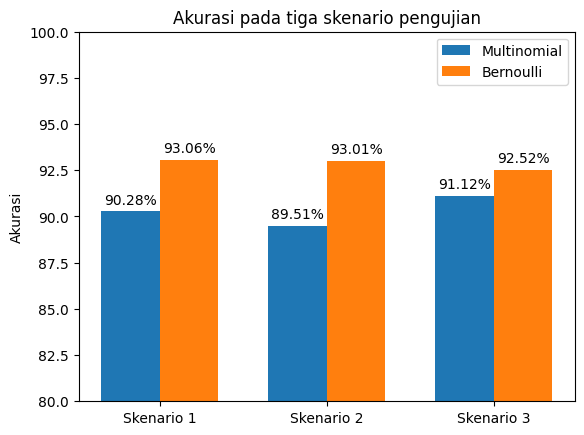

In [ ]:
# Data Akurasi Hasil Penelitian
multinomial = [acc_mnb[0], acc_mnb[1], acc_mnb[2]]
bernoulli = [acc_bnb[0], acc_bnb[1], acc_bnb[2]]
labels = ['Skenario 1', 'Skenario 2', 'Skenario 3']

x = np.arange(len(labels)) # Label skenario pengujian
width = 0.35 # Lebar bar chart
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, multinomial, width, label='Multinomial')
rects2 = ax.bar(x + width/2, bernoulli, width, label='Bernoulli')

# Menambahkan label pada grafik
ax.set_ylabel('Akurasi')
ax.set_title('Akurasi pada tiga skenario pengujian')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# Menambahkan nilai akurasi pada setiap bar chart
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2f}%'.format(height), # menampilkan nilai akurasi dengan format persentase
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3), # 3 points vertical offset
            textcoords="offset points",
            ha='center', va='bottom')
autolabel(rects1)
autolabel(rects2)

ax.set_ylim([80,100])

# Menampilkan grafik
plt.show()


## Diagram Garis Akurasi

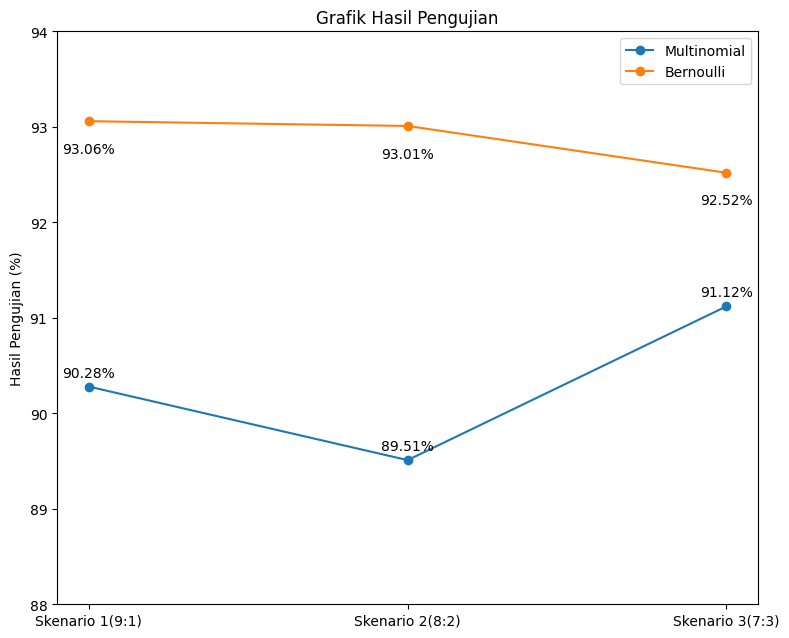

In [ ]:
# Data Akurasi Hasil Penelitian
data = {'Multinomial': ['{:.2f}%'.format(acc_mnb[0]), '{:.2f}%'.format(acc_mnb[1]), '{:.2f}%'.format(acc_mnb[2])],
        'Bernoulli': ['{:.2f}%'.format(acc_bnb[0]), '{:.2f}%'.format(acc_bnb[1]), '{:.2f}%'.format(acc_bnb[2])]}
df = pd.DataFrame(data, index=['Skenario 1(9:1)', 'Skenario 2(8:2)', 'Skenario 3(7:3)'])

df['Multinomial'] = df['Multinomial'].str.strip('%').astype(float)
df['Bernoulli'] = df['Bernoulli'].str.strip('%').astype(float)

# membuat grafik
fig, ax = plt.subplots()
df.plot(ax=ax, kind='line', marker='o')
plt.ylabel('Hasil Pengujian (%)')
plt.title('Grafik Hasil Pengujian')
ax.set_ylim([88,94])

# menambahkan label pada setiap titik data
for i, val in enumerate(df['Multinomial']):
    plt.annotate('{:.2f}%'.format(val), xy=(i, val), xytext=(0, 5), ha='center', va='bottom', textcoords='offset points')
for i, val in enumerate(df['Bernoulli']):
    plt.annotate('{:.2f}%'.format(val), xy=(i, val), xytext=(0, -15), ha='center', va='top', textcoords='offset points')
plt.tight_layout(pad=-5)
plt.xticks(range(len(df.index)), df.index)
plt.show()

# **Wordcloud**

## Wordcloud Positif

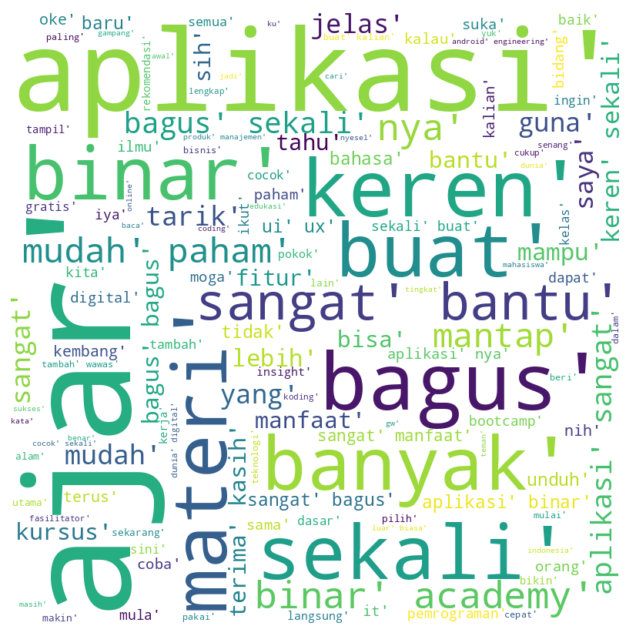

In [ ]:
# memuat dataset
df = pd.read_csv('/content/Preprocessing.csv')

# filter hanya ulasan dengan label positif
ulasan_positif = df.loc[df['label'] == 'POSITIF', 'ulasan']
text = ' '.join(ulasan_positif)

# create wordcloud object
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)

# plot wordcloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


## Wordcloud Negatif

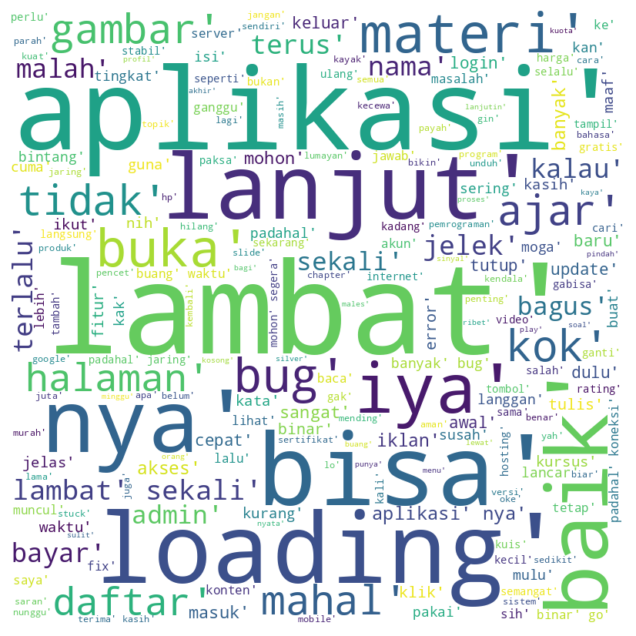

In [ ]:
# memuat dataset
df = pd.read_csv('/content/Preprocessing.csv')

# filter hanya ulasan dengan label negatif
ulasan_negatif = df.loc[df['label'] == 'NEGATIF', 'ulasan']

# concatenate all the text in the 'ulasan_negatif' column into one string
text = ' '.join(ulasan_negatif)

# create wordcloud object
wordcloud = WordCloud(width=800, height=800, background_color='white', min_font_size=10).generate(text)

# plot wordcloud
plt.figure(figsize=(8,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


# **Optional**

## Preprocessing Tanpa Menghapus Data Outlier

In [10]:
# Baca file CSV dan simpan dalam dataframe
df = pd.read_csv(dataset_path)
df_kamus = pd.read_csv(kamus_normalisasi_path)
df_stopword = pd.read_csv(stopword_file_path)

# Tahap Cleaning
def clean_text(text):
    # Menghapus Kata Berulang (Gooool -> Gool)
    pattern = re.compile(r"(.)\1{2,}", re.DOTALL)
    text = pattern.sub(r"\1\1", text)
    # Menghapus emoji, tanda baca, angka dan karakter selain huruf a-z
    text = re.sub(r'[^a-z\s]', ' ', text, flags=re.IGNORECASE)
    return text.strip()
df['ulasan'] = df['ulasan'].apply(clean_text)
df.to_csv('Optional/1. Cleaning.csv', index=False)

# Tahap Case Folding
def case_folding(text):
    text = text.lower()
    return text
df['ulasan'] = df['ulasan'].apply(case_folding)
df.to_csv('Optional/2. Case Folding.csv', index=False)

# Tahap Tokenizing
def tokenizing(text):
    text = word_tokenize(text)
    return text
df['ulasan'] = df['ulasan'].apply(tokenizing)
df.to_csv('Optional/3. Tokenizing.csv', index=False)

# Tahap Normalization
def normalize(text):
    kamus_normalisasi = {}
    for index, row in df_kamus.iterrows():
        kata_asli = row[0]
        kata_normalisasi = row[1]
        kamus_normalisasi[kata_asli] = kata_normalisasi
    text = [kamus_normalisasi.get(token, token) for token in text]
    return text
df['ulasan'] = df['ulasan'].apply(normalize)
df.to_csv('Optional/4. Normalisasi.csv', index=False)

# Tahap Stopword Removal
def stopword_removal(text):
    factory = StopWordRemoverFactory()
    stopword = factory.create_stop_word_remover()
    # Hapus Stopword Manual (Karena Stopword Bahasa Indonesia Tidak Lengkap)
    with open(stopword_file_path, 'r') as f:
        stopword_manual = f.read().split('\n')
    text = [token for token in text if token not in stopword_manual]
    # Hapus Stopword Bawaan Sastrawi
    text = stopword.remove(' '.join(text))
    text = text.split()
    return text
df['ulasan'] = df['ulasan'].apply(stopword_removal)
df.to_csv('Optional/5. Stopword.csv', index=False)

# Tahap Stemming
def stemming(text):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    text = [stemmer.stem(token) for token in text]
    return text
df['ulasan'] = df['ulasan'].apply(stemming)
df.to_csv('Optional/6. Stemming.csv', index=False)

# Simpan Hasil Preprocessing
df.to_csv('Optional/Preprocessing.csv', index=False)

## Program Analisis Sentimen Tanpa Penghapusan Data Outlier

In [13]:
def transformation(n_test_size):
    # memuat dataset
    df = pd.read_csv('/content/Optional/Preprocessing.csv')

    # memisahkan fitur dan label
    x = df['ulasan']
    y = df['label-rating']

    # informasi dataset
    n_review = len(df.index)
    n_pos = sum(y == 'POSITIF')
    n_neg = sum(y == 'NEGATIF')

    # membagi dataset menjadi data training dan data testing
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=n_test_size, random_state=42)

    # simpan hasil data training dan testing lalu urutkan berdasarkan index
    df_train = pd.DataFrame({'ulasan': x_train, 'label': y_train})
    df_test = pd.DataFrame({'ulasan': x_test, 'label': y_test})

    # menghitung jumlah ulasan positif dan negatif pada data testing
    n_pos_test = sum(y_test == 'POSITIF')
    n_neg_test = sum(y_test == 'NEGATIF')

    # menghitung jumlah ulasan positif dan negatif pada data training
    n_pos_train = sum(y_train == 'POSITIF')
    n_neg_train = sum(y_train == 'NEGATIF')

    # ekstraksi fitur menggunakan tf-idf
    vectorizer = TfidfVectorizer()
    x_train_tfidf = vectorizer.fit_transform(x_train)
    x_test_tfidf = vectorizer.transform(x_test)
    n_feature_tfidf = x_train_tfidf.shape[1]

    # hasil ekstraksi fitur menggunakan tf-idf
    feature_names = vectorizer.get_feature_names_out()
    feature_names = np.sort(feature_names)
    df_tfidf = pd.DataFrame(x_train_tfidf.toarray(), columns=feature_names)
    df_tfidf.to_csv('Transformation/tfidf-{}.csv'.format(n_test_size), index=False)

    # seleksi fitur dengan menggunakan information gain
    selector = SelectKBest(mutual_info_classif, k='all')
    x_train = selector.fit_transform(x_train_tfidf, y_train)
    scores = selector.scores_
    selected_features = scores > 0.001
    x_train = x_train[:, selected_features]
    x_test = x_test_tfidf[:, selected_features]
    n_feature_ig = x_train.shape[1]

    # hasil ekstraksi fitur menggunakan information gain
    feature_names = feature_names[selected_features]
    feature_names = np.sort(feature_names)
    df_ig = pd.DataFrame(x_train.toarray(), columns=feature_names)
    df_ig.to_csv('Transformation/ig-{}.csv'.format(n_test_size), index=False)

    return(x_train, x_test, y_train, y_test, n_review, n_pos, n_neg, n_pos_test, n_neg_test, n_pos_train, n_neg_train, n_feature_tfidf, n_feature_ig, df_train, df_test)

In [14]:
def data_mining(x_train, y_train, x_test, y_test, test_size, df_train, df_test):
    # membuat model klasifikasi dengan menggunakan naive bayes
    clf1 = MultinomialNB()
    clf2 = BernoulliNB()

    # melatih model naive bayes dengan data training
    clf1.fit(x_train, y_train)
    clf2.fit(x_train, y_train)

    # melakukan prediksi model naive bayes terhadap data testing
    y_pred1 = clf1.predict(x_test)
    y_pred2 = clf2.predict(x_test)

    # mendapatkan prediksi probabilitas untuk setiap kelas
    y_score1 = clf1.predict_proba(x_test)[:,1]
    y_score2 = clf2.predict_proba(x_test)[:,1]

    # Simpan Hasil Klasifikasi dengan Naive Bayes Multinomial dan Bernoulli kedalam dataframe
    df_test['nb_multinomial'] = y_pred1
    df_test['nb_bernoulli'] = y_pred2

    # Simpan df_test kedalam file csv
    df_test.to_csv('Data Mining/hasil_klasifikasi_nb_{}.csv'.format(test_size), index=True)

    # Gabungkan dan simpan df_train dan df_test kedalam file csv
    df_train = df_train.append(df_test)
    df_train.to_csv('Data Mining/hasil_dataset_{}.csv'.format(test_size),index=True)

    # bersihin output
    clear_output()

    return(y_pred1, y_pred2, y_score1, y_score2)

In [15]:
def evaluation(y_test, y_pred1, y_pred2, y_score1, y_score2, n_pos_test, n_neg_test, n_pos_train, n_neg_train):
    # menghitung performa model dengan menggunakan confusion matrix
    cm_mnb = confusion_matrix(y_test, y_pred1)
    tp_mnb = cm_mnb[1, 1]
    fp_mnb = cm_mnb[1, 0]
    tn_mnb = cm_mnb[0, 0]
    fn_mnb = cm_mnb[0, 1]
    cm_bnb = confusion_matrix(y_test, y_pred2)
    tp_bnb = cm_bnb[1, 1]
    fp_bnb = cm_bnb[1, 0]
    tn_bnb = cm_bnb[0, 0]
    fn_bnb = cm_bnb[0, 1]

    # menghitung metrik evaluasi model multinomial
    accuracy_mnb = accuracy_score(y_test, y_pred1)
    precision_mnb = precision_score(y_test, y_pred1, pos_label='POSITIF')
    recall_mnb = recall_score(y_test, y_pred1, pos_label='POSITIF')
    f1_mnb = f1_score(y_test, y_pred1, pos_label='POSITIF')
    roc_auc_mnb = roc_auc_score(y_test, y_score1)

    # menghitung metrik evaluasi model bernoulli
    accuracy_bnb = accuracy_score(y_test, y_pred2)
    precision_bnb = precision_score(y_test, y_pred2, pos_label='POSITIF')
    recall_bnb = recall_score(y_test, y_pred2, pos_label='POSITIF')
    f1_bnb = f1_score(y_test, y_pred2, pos_label='POSITIF')
    roc_auc_bnb = roc_auc_score(y_test, y_score2)

    # menghitung jumlah ulasan yang terklasifikasi oleh model multinomial
    n_pos_mnb = tp_mnb+fn_mnb+n_pos_train
    n_neg_mnb = fp_mnb+tn_mnb+n_neg_train

    # menghitung jumlah ulasan yang terklasifikasi oleh model bernoulli
    n_pos_bnb = tp_bnb+fn_bnb+n_pos_train
    n_neg_bnb = fp_bnb+tn_bnb+n_neg_train

    return (tp_mnb, fp_mnb, tn_mnb, fn_mnb, tp_bnb, fp_bnb, tn_bnb, fn_bnb, accuracy_mnb, precision_mnb, recall_mnb, f1_mnb, roc_auc_mnb, n_pos_mnb, n_neg_mnb, accuracy_bnb, precision_bnb, recall_bnb, f1_bnb, roc_auc_bnb, n_pos_bnb, n_neg_bnb)

In [16]:
def evaluate_model(test_size):
    # membagi dataset menjadi data training dan data testing
    x_train, x_test, y_train, y_test, n_review, n_pos, n_neg, n_pos_test, n_neg_test, n_pos_train, n_neg_train, n_feature_tfidf, n_feature_ig, df_train, df_test = transformation(test_size)

    # membuat model klasifikasi dengan menggunakan naive bayes
    y_pred1, y_pred2, y_score1, y_score2 = data_mining(x_train, y_train, x_test, y_test, test_size, df_train, df_test)

    # memanggil fungsi untuk melakukan evaluasi model
    tp_mnb, fp_mnb, tn_mnb, fn_mnb, tp_bnb, fp_bnb, tn_bnb, fn_bnb, accuracy_mnb, precision_mnb, recall_mnb, f1_mnb, roc_auc_mnb, n_pos_mnb, n_neg_mnb, accuracy_bnb, precision_bnb, recall_bnb, f1_bnb, roc_auc_bnb, n_pos_bnb, n_neg_bnb = evaluation(y_test, y_pred1, y_pred2, y_score1, y_score2, n_pos_test, n_neg_test, n_pos_train, n_neg_train)

    # konversi accuracy, precision, recall dan f1 menjadi persen
    accuracy_mnb = accuracy_mnb*100
    precision_mnb = precision_mnb*100
    recall_mnb = recall_mnb*100
    f1_mnb = f1_mnb*100
    accuracy_bnb = accuracy_bnb*100
    precision_bnb = precision_bnb*100
    recall_bnb = recall_bnb*100
    f1_bnb = f1_bnb*100

    #konversi roc_auc menjadi 3 angka di belakang koma
    roc_auc_mnb = round(roc_auc_mnb, 3)
    roc_auc_bnb = round(roc_auc_bnb, 3)

    # menyimpan hasil evaluasi model
    skenario = pd.DataFrame({'test_size': [test_size], 'n_review': [n_review], 'n_pos': [n_pos], 'n_neg': [n_neg], 'n_pos_test': [n_pos_test], 'n_neg_test': [n_neg_test], 'n_pos_train': [n_pos_train], 'n_neg_train': [n_neg_train], 'n_feature_tfidf': [n_feature_tfidf], 'n_feature_ig': [n_feature_ig], 'tp_mnb': [tp_mnb], 'fp_mnb': [fp_mnb], 'tn_mnb': [tn_mnb], 'fn_mnb': [fn_mnb], 'tp_bnb': [tp_bnb], 'fp_bnb': [fp_bnb], 'tn_bnb': [tn_bnb], 'fn_bnb': [fn_bnb], 'accuracy_mnb': [accuracy_mnb], 'precision_mnb': [precision_mnb], 'recall_mnb': [recall_mnb], 'f1_mnb': [f1_mnb], 'roc_auc_mnb': [roc_auc_mnb], 'accuracy_bnb': [accuracy_bnb], 'precision_bnb': [precision_bnb], 'recall_bnb': [recall_bnb], 'f1_bnb': [f1_bnb], 'roc_auc_bnb': [roc_auc_bnb], 'n_pos_mnb': [n_pos_mnb], 'n_neg_mnb': [n_neg_mnb], 'n_pos_bnb': [n_pos_bnb], 'n_neg_bnb': [n_neg_bnb]})

    return(skenario)

sk1 = evaluate_model(0.1)
sk2 = evaluate_model(0.2)
sk3 = evaluate_model(0.3)

## Tabel Tabel Hasil Pengujian secara terpisah

In [ ]:
# Tabel Confusion Matrix skenario 1
headers_evaluasi_sk1 = ['Metrics', 'NB Multinomial', 'NB Bernoulli']
table_evaluasi_sk1 = [
    # Cetak Nilai dari values[0]
    ['TP', sk1['tp_mnb'].values[0], sk1['tp_bnb'].values[0]],
    ['FP', sk1['fp_mnb'].values[0], sk1['fp_bnb'].values[0]],
    ['TN', sk1['tn_mnb'].values[0], sk1['tn_bnb'].values[0]],
    ['FN', sk1['fn_mnb'].values[0], sk1['fn_bnb'].values[0]],
    ['Akurasi', acc_mnb[0], acc_bnb[0]],
    ['Presisi', prec_mnb[0], prec_bnb[0]],
    ['Recall', rec_mnb[0], rec_bnb[0]],
    ['F1-Score', f1_mnb[0], f1_bnb[0]],
    ['ROC AUC', roc_auc_mnb[0], roc_auc_bnb[0]]
]

# Tabel Confusion Matrix skenario 2
headers_evaluasi_sk2 = ['Metrics', 'NB Multinomial', 'NB Bernoulli']
table_evaluasi_sk2 = [
    # Cetak Nilai dari values[0]
    ['TP', sk2['tp_mnb'].values[0], sk2['tp_bnb'].values[0]],
    ['FP', sk2['fp_mnb'].values[0], sk2['fp_bnb'].values[0]],
    ['TN', sk2['tn_mnb'].values[0], sk2['tn_bnb'].values[0]],
    ['FN', sk2['fn_mnb'].values[0], sk2['fn_bnb'].values[0]],
    ['Akurasi', acc_mnb[1], acc_bnb[1]],
    ['Presisi', prec_mnb[1], prec_bnb[1]],
    ['Recall', rec_mnb[1], rec_bnb[1]],
    ['F1-Score', f1_mnb[1], f1_bnb[1]],
    ['ROC AUC', roc_auc_mnb[1], roc_auc_bnb[1]]
]

# Tabel Confusion Matrix skenario 3
headers_evaluasi_sk3 = ['Metrics', 'NB Multinomial', 'NB Bernoulli']
table_evaluasi_sk3 = [
    # Cetak Nilai dari values[0]
    ['TP', sk3['tp_mnb'].values[0], sk3['tp_bnb'].values[0]],
    ['FP', sk3['fp_mnb'].values[0], sk3['fp_bnb'].values[0]],
    ['TN', sk3['tn_mnb'].values[0], sk3['tn_bnb'].values[0]],
    ['FN', sk3['fn_mnb'].values[0], sk3['fn_bnb'].values[0]],
    ['Akurasi', acc_mnb[2], acc_bnb[2]],
    ['Presisi', prec_mnb[2], prec_bnb[2]],
    ['Recall', rec_mnb[2], rec_bnb[2]],
    ['F1-Score', f1_mnb[2], f1_bnb[2]],
    ['ROC AUC', roc_auc_mnb[2], roc_auc_bnb[2]]
]

print("\nHasil Evaluasi Model Skenario 1")
print(tabulate(table_evaluasi_sk1, headers_evaluasi_sk1, tablefmt="fancy_grid"))
print("\nHasil Evaluasi Model Skenario 2")
print(tabulate(table_evaluasi_sk2, headers_evaluasi_sk2, tablefmt="fancy_grid"))
print("\nHasil Evaluasi Model Skenario 3")
print(tabulate(table_evaluasi_sk3, headers_evaluasi_sk3, tablefmt="fancy_grid"))